In [1]:
# Python imports
import os
import re
## Science
import numpy as np
import pandas as pd
from scipy import optimize as scopt
from scipy.integrate import solve_ivp
from scipy.stats import norm as snorm
from scipy import stats
import scipy.stats as stats
import scipy.integrate as scint
import scipy.interpolate as scinterp
## Plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
import seaborn as sns

# Custom imports
import pyEnceladus.universal_htv as uhtv
import pyEnceladus.data_htv as dhtv
import pyEnceladus.physical as phc
import pyEnceladus.plot_tools as cplt
from pyEnceladus.biosims import makePriors, makeOnePrior
from pyEnceladus.plot_abc import confusion_format
import pyEnceladus.simulation_qstar as smqs
# Customize plots
SMALL_SIZE = 5.5
BIG_SIZE  = 8
AV_SIZE = 7

mpl.rc('axes', labelsize=AV_SIZE)
mpl.rc('legend', fontsize=AV_SIZE)
mpl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=SMALL_SIZE)
mpl.rc('text',usetex=False)

mpl.rcParams['hatch.linewidth'] = 6

palette = sns.color_palette('colorblind')

col_dict  = {'H2':'dodgerblue','CO2':'orangered','CH4':'seagreen'}
col_list  = [col_dict[key] for key in col_dict.keys()]
basic_linewidth = mpl.rcParams['hatch.linewidth']

## Demonstration data

Here, we generate an example, reproducible, very small dataset of parameters (ocean and HF composition), that is used to plot illustrations of the model.

In [2]:
# Generating example data from distributions specified in demo_bounds.csv and using 42 as seed.
## Uncomment the first two lines to rewrite the saved file

#rndgen = np.random.RandomState(seed=42)
#makePriors('data/demo/demo_bounds.csv',5,'demo',rndgen=rndgen)
priors = pd.read_csv('../data/demo/demo.prior.csv',delimiter=';',index_col=0)
priors

,H2o,H2f,CO2o,CO2f,CH4o,CH4f,Tf
0,8.044857e-08,4.980985e-06,5.737319e-07,6.575221e-08,9.987895e-05,1.122438e-05,421.508970
1,3.358208e-08,2.419040e-02,2.863701e-06,2.010277e-02,6.203082e-08,2.903988e-08,334.104825
2,4.544809e-05,9.644580e-04,5.383839e-05,3.228119e-03,3.277135e-06,1.991048e-07,313.010319
3,4.269603e-06,1.352730e-04,1.566079e-05,8.431357e-07,8.784083e-06,5.076662e-07,489.777107
4,1.108804e-05,1.991718e-07,2.408441e-06,5.618006e-07,8.982238e-09,1.573695e-06,493.126407


In [3]:
# Storing data in variables
rk    = 1   # We take the line 1 of the example prior table (line 1 is second line)
Tf    = priors['Tf'][rk]
keys  = ['H2','CO2','CH4']
fconc = {key:priors[key+'f'][rk] for key in keys}
oconc = {key:priors[key+'o'][rk] for key in keys}
# Space
Rmax = 100                   # radius of the hot spot (m)
r    = np.arange(0,Rmax,.1)  # coordinate vector (m)
# Constants
g       = 0.12 # gravity (Choblet) (m.s-2)
alpha   = 3e-4 # Thermal expansion coefficient (Choblet) (K-1)
epsilon = 1    # Mixing layer thickness (m)
# Other parameters setting
F    = 10e9 # hot-spot power W
To   = 275  # oceanic temperature K
Jmax = phc.buoyflux(epsilon,g,Tf,To)
c    = phc.t_grad_par(F,Tf,To,Jmax=Jmax)

## A quick overview of the physical model

In [4]:
jf = phc.thermflux(c,Jmax,r) # Solve the mass flux density entering the ML
T = phc.localtempss(jf,Tf,To,epsilon,g)  # Solve the temperature structure in the ML
jc = phc.buoyflux(epsilon,g,T,To) # Solve the steady-state escape rate of ML waters

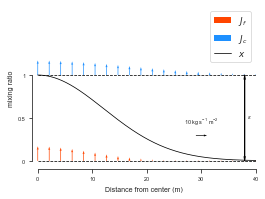

In [5]:
sns.set_style('white',{'xtick.bottom':True,'ytick.left':True})
fig, ax = plt.subplots(figsize=(4,3))
sns.set_context('paper')

adv = cplt.plotAdvection(ax,r,c,Jmax,Tf,To,epsilon,g,sup=40,hlength=0.05)
ax.set_ylabel('mixing ratio')
#plt.savefig('vent_model.png',dpi=400,bbox_inches='tight')
plt.show()

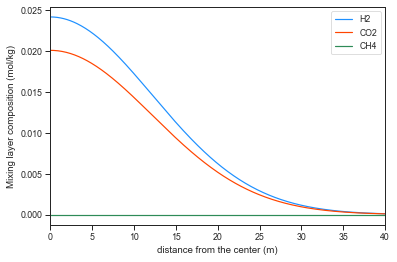

In [6]:
concentrations = phc.abiotic_conc(oconc,fconc,jf,jc)

fig, ax = plt.subplots()
handles = []
for key in keys:
    ln, = ax.plot(r,concentrations[key],color=col_dict[key])
    handles.append(ln)
plt.legend(handles=handles,labels=keys)
plt.xlabel('distance from the center (m)')
plt.ylabel('Mixing layer composition (mol/kg)')
plt.xlim(0,40)
plt.show()

### Mixing the waters escaping ML into an homogeneous plume

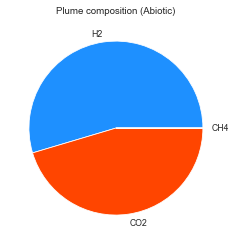

In [7]:
plume_composition_abiotic = phc.PlumeMixing(jc,concentrations,r,0.1)
pie_ab = []
total = np.sum([plume_composition_abiotic[key] for key in keys])
for key in keys:
    pie_ab.append(360*plume_composition_abiotic[key]/total)
plt.pie(pie_ab,labels=keys,colors=col_list)
plt.title('Plume composition (Abiotic)')
plt.show()

## Biological model


In [8]:
# Biological parameters
cellrad = 1 # cell radius in micrometer
cellvol = (4/3)*np.pi*cellrad**3 # cell volume
bstruct = uhtv.Bstruct(cellvol) # Structural mass of the cell
qmaxfun = uhtv.Vmax(**dhtv.methanogens) # Maximal catabolic rate as a function of temperature, using parameters of methanogens
bpar = {'dgdiss':uhtv.Dgdiss(**dhtv.methanogens),
        'kd':1e-3,
        'bstruct':bstruct,
        'dg0scat':dhtv.BioRunMeth['dg0scat'],
        'dh0scat':dhtv.BioRunMeth['dh0scat'],
        'tau':dhtv.BioRunMeth['tau'],
        'dth':0.,
        'dth_con':0.03,
        'rmax':72,
        'theta':dhtv.BioRunMeth['theta'],
        'qmaxfun':qmaxfun}
qcat = qmaxfun(T)*bpar['tau'] # Scaling the catabolic rate to cell mass rather than enzyme quantity
Stoi = np.array([-1,-0.25,0.25]) # Stoichiometry of hydrogenotrophic methanogens (H2,CO2,CH4)

### Estimation of scaling parameter $\tau$ using growth curves in Taubner 2018

In [9]:
# Loading ranges of measured optical densities for M. villosus
taubner_hi = pd.read_csv('../data/taubner2018/data_mvillosus_stdrd_h2co2_hi.csv')
taubner_lo = pd.read_csv('../data/taubner2018/data_mvillosus_stdrd_h2co2_low.csv')
taubner_mid = pd.read_csv('../data/taubner2018/data_mvillosus_stdrd_h2co2.csv')
H = dhtv.Taubner2018_H2CO2['H2']
C = dhtv.Taubner2018_H2CO2['CO2']
N = dhtv.Taubner2018_H2CO2['NH4']
G = dhtv.Taubner2018_H2CO2['CH4']
CC = np.array([H,C,G])
SS = np.array([-1,-0.25,0.25])
Q = np.product(CC**SS)

T = np.arange(0,200,0.1)+273.15

In [10]:
dhtv.Taubner2018_H2CO2

{'Tmax': 353.15,
 'pH': 7,
 'H2': 0.00152,
 'CH4': 1e-10,
 'CO2': 0.007730000000000001,
 'NH4': 1e-05}

In [11]:
tt = taubner_hi['time']
odhi = taubner_hi['OD']
odlo = taubner_lo['OD']
od = taubner_mid['OD']

ttest = np.arange(0,200,1)/24

# Error bars from Taubner 2018
yerr = (odhi-odlo)/2
yerr[0] = 0

Because the data in Taubner the cell count is approximated by optical density so that we just fit a classical verhulst model for growth parameter $r$, and then we relate $r$ to the growth rate in our model so that the order of magnitude is right.

In [12]:
def verhulst(t,r,k,y0):
    return(k/(1+((k/y0)-1)*np.exp(-r*t)))
# Fit parameters K and r (and y0)
sigma = np.array(yerr)/2
sigma[0] = 0.02
popt,pcov = scopt.curve_fit(verhulst,tt/24,od,sigma=sigma) #parameters in d-1
popt # Parameters r,k and y0 estimated by least mean square

array([2.54881293, 0.55184193, 0.03259591])

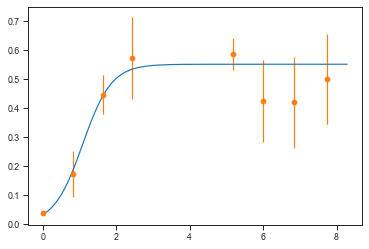

In [13]:
## Plot the verhulst curve with fitted r0 parameter and data
plt.plot(ttest,verhulst(ttest,*popt))
plt.errorbar(tt/24,od,yerr,fmt='o')
plt.show()

In [14]:
# Estimate tau from fitted r0 assuming that the experiment temperature is in 64,66 C

def InitialParam(Q,T, qmaxfun, dgdiss, bstruct,dg0scat,dh0scat,dth,rmax,theta,kd,**kwargs):
    """
    Initial values allowing to estimate tau
    """
    qe    = qmaxfun(T)
    dgcat = uhtv.DeltaG(Q,T,dg0scat,dh0scat)
    em    = uhtv.MaintenanceE(T)
    qm    = -em/dgcat
    lam   = -dgcat/dgdiss
    return(lam,qm,qe)

def tau_est(r,lam,qm,qe):
    return(((r/lam)+qm)/qe)

lam80,qm80,qe80 = InitialParam(Q,80+273.15,**bpar) # parameters at 80 celsius
lam79,qm79,qe79 = InitialParam(Q,80+273.15-1,**bpar) # parameters at 79 celsius
lam81,qm81,qe81 = InitialParam(Q,80+273.15+1,**bpar) # parameters at 81 celsius

r_est = popt[0]

tau80 = tau_est(r_est,lam80,qm80,qe80) # tau estimate at 65 celsius
tau79 = tau_est(r_est,lam79,qm79,qe79) # tau estimate at 64 celsius
tau81 = tau_est(r_est,lam81,qm81,qe81) # tau estimate at 66 celsius

print(tau79,tau80,tau81)

1.7459761536997586e-05 1.728372054314077e-05 1.7202594402114066e-05


In [15]:
# Get initial growth rate, cell mass, death rate and catabolic rate from the thermodynamical model at temperatures and composition in Taubner using our tau estimate
## 
r080,bstar, d, qcat = uhtv.Nderpar(Q,80+273.15, **bpar)
r081,bstar, d, qcat = uhtv.Nderpar(Q,80+273.15+1, **bpar)
r079,bstar, d, qcat = uhtv.Nderpar(Q,80+273.15-1, **bpar)

In [16]:
# A scaled logistic equation with rb as the initial growth rate to draw verhulst curves from the thermodynamics model outputs
def traj(t,rb,np0):
    return(np.exp(rb*t)/(1/np0-1+np.exp(rb*t)))

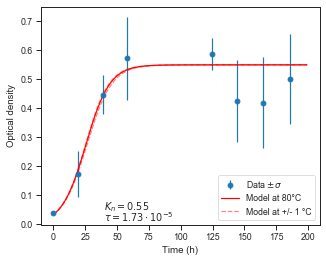

In [17]:
plt.figure(figsize=(5,4))
K = 0.55
taubner = plt.errorbar(tt,od,yerr,fmt='o')
mod65, = plt.plot(ttest*24,traj(ttest,r080,odhi[0]/K)*K,'r')
mod1, = plt.plot(ttest*24,traj(ttest,r081,odhi[0]/K)*K,'--r',alpha=0.5)
plt.plot(ttest*24,traj(ttest,r079,odhi[0]/K)*K,'--r',alpha=0.5)
plt.ylabel('Optical density')
plt.xlabel('Time (h)')
plt.text(40,0.05,r'$K_n=0.55$')
plt.text(40,0.01,r'$\tau = 1.73 \cdot 10^{-5}$')
plt.legend([taubner,mod65,mod1],['Data $\pm \sigma$','Model at 80°C','Model at +/- 1 °C'],loc='lower right')
#plt.savefig('fit_taubner.png',dpi=400)
plt.show()

### Numerically solving the biological model and validate predicted steady-state

In [18]:
bpar['tau']

1.73e-05

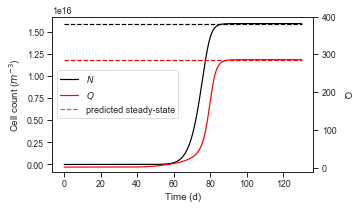

In [19]:
di     = 50 # position around the hotspot (rank)
jf = phc.thermflux(c,Jmax,r)
T = phc.localtempss(jf,Tf,To,epsilon,g)
jc = phc.buoyflux(epsilon,g,T,To)
concentrations = phc.abiotic_conc(oconc,fconc,jf,jc)
qcat = qmaxfun(T)*bpar['tau']
C0     = {key:concentrations[key][di] for key in keys}
Y0     = np.array([100,C0['H2'],C0['CO2'],C0['CH4']])
Jf     = jf[di]
Jc     = jc[di]
t_span = [0,130] # integration time
Tmp    = T[di]
qcat = qmaxfun(T)*bpar['tau']
# Numerical solution
sol_n    = uhtv.MethDynInt(Y0,t_span,Tmp, Jf, Jc, oconc, fconc,epsilon=epsilon,
                           method='BDF',dth=bpar['dth_con'],kd=bpar['kd'],tau=bpar['tau'],
                           theta=bpar['theta'],rmax=bpar['rmax'],qmaxfun=bpar['qmaxfun'],
                           dgdiss=bpar['dgdiss'],bstruct=bpar['bstruct'],
                           dg0scat=bpar['dg0scat'],dh0scat=bpar['dh0scat'],atol=1e-14,rtol=1e-14)
Qt_n     = [uhtv.ReactionQuotient(np.array([sol_n.y[i][j] for i in range(1,4)]),np.array([-1,-0.25,0.25])) for j in range(len(sol_n.t))]
# Analytical prediction of steady state
## Only qstar
Qs_a     = uhtv.QstarVal(T,DG0=uhtv.DeltaG0(T,DG0S=bpar['dg0scat'],DH0S=bpar['dh0scat']),
                         em=uhtv.MaintenanceE(T),dgdiss=bpar['dgdiss'],qcat=qcat,dth=bpar['dth_con'])
## Back to the concentrations
sol_a, s = uhtv.RunBioHTV_Qstar(concentrations,T,
                                dg0cat=uhtv.DeltaG0(T,DG0S=bpar['dg0scat'],DH0S=bpar['dh0scat']),
                                em=uhtv.MaintenanceE(T),dgdiss=bpar['dgdiss'],
                                qcat=qcat,dth=bpar['dth_con'],Stoi=Stoi)
## Population steady-state
bstar    = uhtv.Bstar(bpar['dth_con'],bpar['bstruct'],bpar['rmax'],bpar['theta'])
ns_a     = uhtv.Nstar(bstar=bstar,Jf=Jf,Jc=Jc,cfed=fconc['H2'],coed=oconc['H2'],cstared=sol_a['H2'][di],qcat=qcat[di])

fig, ax = plt.subplots(figsize=(5,3))
nplot, = ax.plot(sol_n.t,sol_n.y[0],color='k')
ax.plot(t_span,[ns_a,ns_a],'k--')
ax.set_xlabel('Time (d)')
ax.set_ylabel('Cell count ($m^{-3}$)')

ax2 = ax.twinx()
qplot, = ax2.plot(sol_n.t,Qt_n,color='red')
ax2.plot(t_span,[Qs_a[di],Qs_a[di]],'r--')
ax2.set_ylim(-10,400)
ax2.set_ylabel('Q',labelpad=15,rotation=270)
ax2.yaxis.set_label_position("right")

dummyline = plt.Line2D((0,1),(0,0),linestyle='--',color='grey')

ax.legend(handles=[nplot,qplot,dummyline],labels=['$N$','$Q$','predicted steady-state'],fontsize=9)
plt.tight_layout()
#plt.savefig('trajectory.png',dpi=400)
plt.show()

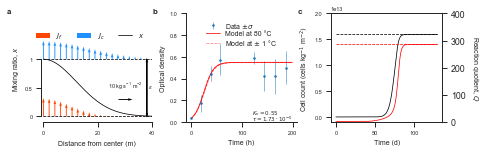

In [21]:
## Plotting the Extended Data Figure 1
mpl.rc('axes', labelsize=AV_SIZE)
mpl.rc('legend', fontsize=AV_SIZE)
mpl.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
mpl.rc('ytick', labelsize=SMALL_SIZE)
mpl.rc('text',usetex=False)
fig, axes = plt.subplots(figsize=(7.2,2),ncols=3,nrows=1)
sns.set_context('paper')

# Plotting a
adv = cplt.plotAdvection(axes[0],r,c,Jmax,Tf,To,epsilon,g,sup=40,loc='upper left',awidth=0.1,hlength=0.05,
                         bbox_to_anchor=(-0.1,0.9),labelspacing=0.1,fontsize=7,frameon=False,ncol=3,scale=0.0025,width=0.008)
axes[0].set_ylabel('Mixing ratio, $x$')
# Plotting b
K = 0.55
taubner = axes[1].errorbar(tt,od,yerr,fmt='o',markersize=1.5,linewidth=0.5)   # Plotting error bars
mod80, = axes[1].plot(ttest*24,traj(ttest,r080,odhi[0]/K)*K,'r',linewidth=0.75) # median temperature verhulst equivalent of model
mod1, = axes[1].plot(ttest*24,traj(ttest,r081,odhi[0]/K)*K,'--r',alpha=0.5,linewidth=0.75) # +1C difference verhulst equivalent
axes[1].plot(ttest*24,traj(ttest,r079,odhi[0]/K)*K,'--r',alpha=0.5,linewidth=0.75) # -1C

axes[1].set_ylabel('Optical density')
axes[1].set_xlabel('Time (h)')
axes[1].text(120,0.07,r'$K_n=0.55$',fontsize=5.5,ha='left')
axes[1].text(120,0.01,r'$\tau = 1.73 \cdot 10^{-5}$',fontsize=5.5,ha='left')
axes[1].set_ylim(0,1)
axes[1].legend([taubner,mod80,mod1],['Data $\pm \sigma$','Model at 80 °C','Model at $\pm$ 1 °C'],fontsize=7,labelspacing=0.1,frameon=False,loc='upper center')
sns.despine(ax=axes[1])

# Plotting c
nplot, = axes[2].plot(sol_n.t,sol_n.y[0]/1000,color='k',linewidth=0.75)
axes[2].plot(t_span,np.array([ns_a,ns_a])/1000,'k--',linewidth=0.75)
axes[2].set_xlabel('Time (d)')
axes[2].set_ylabel('Cell count (cells $\mathregular{kg}^{-1}~\mathregular{m}^{-2}$)')
axes[2].set_ylim(-1e12,2e13)

ax2 = axes[2].twinx()
qplot, = ax2.plot(sol_n.t,Qt_n,color='red',linewidth=0.75)
ax2.plot(t_span,[Qs_a[di],Qs_a[di]],'r--',linewidth=0.75)


ax2.set_ylim(-1,400)
#ax2.set_yticks([0,4000,8000,12000,16000,20000,24000])
#ax2.set_yticklabels(labels=[0,4000,8000,12000,16000,20000,24000],fontsize=5.5)
ax2.set_ylabel('Reaction quotient, $Q$',labelpad=15,rotation=270,fontsize=7)
ax2.yaxis.set_label_position("right")


dummyline = plt.Line2D((0,1),(0,0),linestyle='--',color='grey')

for i,l in enumerate(['a','b','c']):
    axes[i].text(-0.3,1,l,weight='bold',size=8,transform=axes[i].transAxes)

plt.subplots_adjust(wspace=0.3, hspace=0.25)

#plt.savefig('agg_bgmodel.png',bbox_inches='tight',dpi=400)

plt.show()

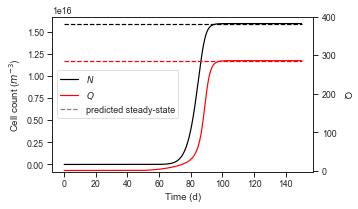

In [22]:
di     = 50 # position around the hotspot (rank)
jf = phc.thermflux(c,Jmax,r)
T = phc.localtempss(jf,Tf,To,epsilon,g)
jc = phc.buoyflux(epsilon,g,T,To)
concentrations = phc.abiotic_conc(oconc,fconc,jf,jc)
qcat = qmaxfun(T)*bpar['tau']
Y0     = np.array([1,concentrations['H2'][di],concentrations['CO2'][di],concentrations['CH4'][di]])
C0     = {key:concentrations[key][di] for key in keys}
Jf     = jf[di]
Jc     = jc[di]
t_span = [0,150] # integration time
Tmp    = T[di]
qcat = qmaxfun(T)*bpar['tau']
# Numerical solution
sol_n    = uhtv.MethDynInt(Y0,t_span,Tmp, Jf, Jc, oconc, fconc,epsilon=epsilon,
                           method='BDF',dth=bpar['dth_con'],kd=bpar['kd'],tau=bpar['tau'],
                           theta=bpar['theta'],rmax=bpar['rmax'],qmaxfun=bpar['qmaxfun'],
                           dgdiss=bpar['dgdiss'],bstruct=bpar['bstruct'],
                           dg0scat=bpar['dg0scat'],dh0scat=bpar['dh0scat'])
Qt_n     = [uhtv.ReactionQuotient(np.array([sol_n.y[i][j] for i in range(1,4)]),np.array([-1,-0.25,0.25])) for j in range(len(sol_n.t))]
# Analytical prediction of steady state
## Only qstar
Qs_a     = uhtv.QstarVal(T,DG0=uhtv.DeltaG0(T,DG0S=bpar['dg0scat'],DH0S=bpar['dh0scat']),
                         em=uhtv.MaintenanceE(T),dgdiss=bpar['dgdiss'],qcat=qcat,dth=bpar['dth_con'])
## Back to the concentrations
sol_a, s = uhtv.RunBioHTV_Qstar(concentrations,T,
                                dg0cat=uhtv.DeltaG0(T,DG0S=bpar['dg0scat'],DH0S=bpar['dh0scat']),
                                em=uhtv.MaintenanceE(T),dgdiss=bpar['dgdiss'],
                                qcat=qcat,dth=bpar['dth_con'],Stoi=Stoi)
## Population steady-state
bstar    = uhtv.Bstar(bpar['dth_con'],bpar['bstruct'],bpar['rmax'],bpar['theta'])
ns_a     = uhtv.Nstar(bstar=bstar,Jf=Jf,Jc=Jc,cfed=fconc['H2'],coed=oconc['H2'],cstared=sol_a['H2'][di],qcat=qcat[di])

fig, ax = plt.subplots(figsize=(5,3))
nplot, = ax.plot(sol_n.t,sol_n.y[0],color='k')
ax.plot(t_span,[ns_a,ns_a],'k--')
ax.set_xlabel('Time (d)')
ax.set_ylabel('Cell count ($m^{-3}$)')

ax2 = ax.twinx()
qplot, = ax2.plot(sol_n.t,Qt_n,color='red')
ax2.plot(t_span,[Qs_a[di],Qs_a[di]],'r--')
ax2.set_ylim(-1,400)
ax2.set_ylabel('Q',labelpad=15,rotation=270)
ax2.yaxis.set_label_position("right")

dummyline = plt.Line2D((0,1),(0,0),linestyle='--',color='grey')

ax.legend(handles=[nplot,qplot,dummyline],labels=['$N$','$Q$','predicted steady-state'],fontsize=9)
plt.tight_layout()
#plt.savefig('trajectory.png',dpi=400)
plt.show()

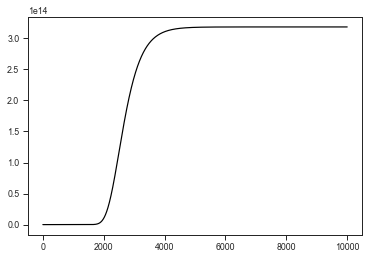

In [23]:
di     = 50 # position around the hotspot (rank)
jf = phc.thermflux(c,Jmax,r)
Tf = 300
To = 270
T = phc.localtempss(jf,Tf,To,epsilon,g)
jc = phc.buoyflux(epsilon,g,T,To)
concentrations = phc.abiotic_conc(oconc,fconc,jf,jc)
qcat = qmaxfun(T)*bpar['tau']
Y0     = np.array([1,concentrations['H2'][di],concentrations['CO2'][di],concentrations['CH4'][di]])
C0     = {key:concentrations[key][di] for key in keys}
Jf     = jf[di]
Jc     = jc[di]
t_span = [0,10000] # integration time
Tmp    = T[di]
qcat = qmaxfun(T)*bpar['tau']
# Numerical solution
sol_n    = uhtv.MethDynInt(Y0,t_span,Tmp, Jf, Jc, oconc, fconc,epsilon=epsilon,
                           method='BDF',dth=bpar['dth_con'],kd=bpar['kd'],tau=bpar['tau'],
                           theta=bpar['theta'],rmax=bpar['rmax'],qmaxfun=bpar['qmaxfun'],
                           dgdiss=bpar['dgdiss'],bstruct=bpar['bstruct'],
                           dg0scat=bpar['dg0scat'],dh0scat=bpar['dh0scat'])

plt.plot(sol_n.t,sol_n.y[0],color='k')

In [58]:
Tf = 300
otemp = np.linspace(230,275,100)
thalf = []
nstar = []
dtime = []
for To in otemp:
    T = phc.localtempss(jf,Tf,To,epsilon,g)
    jc = phc.buoyflux(epsilon,g,T,To)
    concentrations = phc.abiotic_conc(oconc,fconc,jf,jc)
    qcat = qmaxfun(T)*bpar['tau']
    Y0     = np.array([1,concentrations['H2'][di],concentrations['CO2'][di],concentrations['CH4'][di]])
    C0     = {key:concentrations[key][di] for key in keys}
    Jf     = jf[di]
    Jc     = jc[di]
    t_span = [0,1000000] # integration time
    Tmp    = T[di]
    qcat = qmaxfun(T)*bpar['tau']
    # Numerical solution
    sol_n    = uhtv.MethDynInt(Y0,t_span,Tmp, Jf, Jc, oconc, fconc,epsilon=epsilon,
                               method='BDF',dth=bpar['dth_con'],kd=bpar['kd'],tau=bpar['tau'],
                               theta=bpar['theta'],rmax=bpar['rmax'],qmaxfun=bpar['qmaxfun'],
                               dgdiss=bpar['dgdiss'],bstruct=bpar['bstruct'],
                               dg0scat=bpar['dg0scat'],dh0scat=bpar['dh0scat'])
    max_der_rk = np.argmax(np.gradient(sol_n.y[0],sol_n.t))
    dmax = np.max(np.gradient(sol_n.y[0],sol_n.t))
    if sol_n.y[0][-1]< 1e-3:
        half = np.inf
    else:
        half = sol_n.t[np.argmax(max_der_rk)]
    thalf.append(half)
    nstar.append(sol_n.y[0][-1])
    dtime.append((sol_n.y[0][max_der_rk]/dmax)*np.log(2))

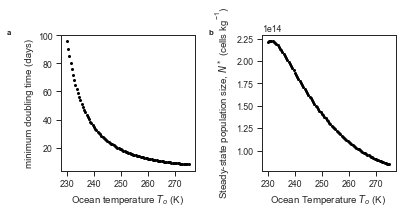

In [59]:
fig,axes = plt.subplots(figsize=(6,2.5),ncols=2,nrows=1)
axes[0].plot(otemp,dtime,'k.',ms=4)
axes[0].set_ylabel('minimum doubling time (days)')
axes[0].set_xlabel('Ocean temperature $T_o$ ($\mathregular{K}$)')
axes[1].plot(otemp,np.array(nstar)/1000,'k.',ms=4)
axes[1].set_ylabel('Steady-state population size, $N^*$ ($\mathregular{cells}~\mathregular{kg^{-1}}$)')
axes[1].set_xlabel('Ocean Temperature $T_o$ ($\mathregular{K}$)')

plt.subplots_adjust(wspace=0.5, hspace=0.25)
axes[0].text(-0.4,1,'a',weight='bold',size=8,transform=axes[0].transAxes)
axes[1].text(-0.4,1,'b',weight='bold',size=8,transform=axes[1].transAxes)

#plt.savefig('temperature_sensi.png',bbox_inches='tight',dpi=400)
plt.show()

## Hot-spot structure accounting for methanogenic life

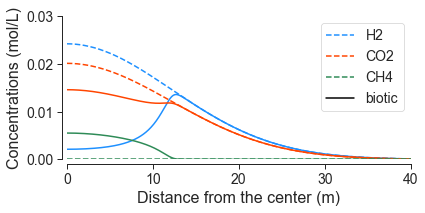

In [44]:
handles = []
fig, ax  = plt.subplots(figsize=(6,3))
qab = []
qbi = []

fconc = {key:priors[key+'f'][rk] for key in keys}
oconc = {key:priors[key+'o'][rk] for key in keys}
# Space
Rmax = 100                   # radius of the hot spot (m)
r    = np.arange(0,Rmax,.1)  # coordinate vector (m)
# Constants
g       = 0.12 # gravity (Choblet) (m.s-2)
alpha   = 3e-4 # Thermal expansion coefficient (Choblet) (K-1)
epsilon = 1    # Mixing layer thickness (m)
# Other parameters setting
F    = 10e9 # hot-spot power W
To   = 275  # oceanic temperature K
Jmax = phc.buoyflux(epsilon,g,Tf,To)
c    = phc.t_grad_par(F,Tf,To,Jmax=Jmax)

Tf    = priors['Tf'][rk]
jf = phc.thermflux(c,Jmax,r)
T = phc.localtempss(jf,Tf,To,epsilon,g)
jc = phc.buoyflux(epsilon,g,T,To)
concentrations = phc.abiotic_conc(oconc,fconc,jf,jc)
qcat = qmaxfun(T)*bpar['tau']
qcat = qmaxfun(T)*bpar['tau']

sol_a, s = uhtv.RunBioHTV_Qstar(concentrations,T,
                                dg0cat=uhtv.DeltaG0(T,DG0S=bpar['dg0scat'],DH0S=bpar['dh0scat']),
                                em=uhtv.MaintenanceE(T),dgdiss=bpar['dgdiss'],
                                qcat=qcat,dth=bpar['dth_con'],Stoi=Stoi)

# Solve the model over the ML
for i in range(len(r)):
    q = concentrations['CH4'][i]**0.25/((concentrations['CO2'][i]**0.25)*concentrations['H2'][i])
    qb= sol_a['CH4'][i]**0.25/((sol_a['CO2'][i]**0.25)*sol_a['H2'][i])
    qab.append(q)
    qbi.append(qb)
dotted_line = mlines.Line2D([], [], color='k', linestyle='-',linewidth=1.5)

# Plot
for key in keys:
    ax.plot(r,sol_a[key],color=col_dict[key],lw=1.5)
    h, = ax.plot(r,concentrations[key],color=col_dict[key],linestyle='--',lw=1.5)
    handles.append(h)
    
ax.set_ylabel('Concentrations (mol/L)',fontsize=16)
ax.set_xlabel('Distance from the center (m)',fontsize=16)
ax.set_ylim(0,0.03)
ax.set_yticks([0,0.01,0.02,0.03])

# Plot Q
#ax2 = ax.twinx()
#ax2.plot(r,np.log10(qab),'k--')
#qline, = ax2.plot(r,np.log10(qbi),'k-')
#ax2.set_ylim(0,6)
#ax2.set_ylabel('Q (log)',rotation=270,labelpad=15)

#handles.append(qline)
handles.append(dotted_line)
ax.set_xticks([0,10,20,30,40])
ax.tick_params(labelsize=14)
ax.legend(handles=handles,labels=keys+['biotic'],fontsize=14)
ax.set_xlim(0,40)
sns.despine(trim=True,top=True,right=True,offset=5)
plt.tight_layout()
#plt.savefig('profile_bi.png',dpi=400,bbox_inches='tight')
plt.show()

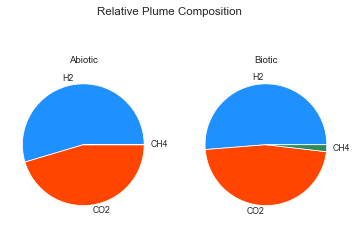

In [44]:
# Compute and plot plume compisition with and without methanogenic activity

plume_composition_biotic = phc.PlumeMixing(jc,sol_a,r,0.1)
pie_bio = []
total = np.sum([plume_composition_biotic[key] for key in keys])
for key in keys:
    pie_bio.append(360*plume_composition_biotic[key]/total)
fig, axes = plt.subplots(ncols=2,nrows=1)
axes[0].pie(pie_ab,labels=keys,colors=col_list)
axes[0].set_title('Abiotic')
axes[1].pie(pie_bio,labels=keys,colors=col_list)
axes[1].set_title('Biotic')
plt.suptitle('Relative Plume Composition')
#plt.savefig('figures/piecharts_plume.pdf')
plt.show()

## Habitable conditions and details on intracellular processes

In [262]:
Tspace    = np.linspace(273,400,100)
qcatfun   = lambda T : qmaxfun(T)*bpar['tau']
qstarfun  = lambda T : uhtv.QstarVal(T,DG0=uhtv.DeltaG0(T,DG0S=bpar['dg0scat'],DH0S=bpar['dh0scat']),
                         em=uhtv.MaintenanceE(T),dgdiss=bpar['dgdiss'],qcat=qcatfun(T),dth=bpar['dth_con'])
KPfun     = lambda T : np.exp(-(uhtv.DeltaG0(T,bpar['dg0scat'],bpar['dh0scat'])/(uhtv.glo_R*T)))
dgatp     = -30e3
Qatpfun   = lambda T : np.exp((dgatp-uhtv.DeltaG0(T,bpar['dg0scat'],bpar['dh0scat']))/(uhtv.glo_R*T))
Qstar     = qstarfun(Tspace)
KP        = KPfun(Tspace)
QATP      = Qatpfun(Tspace)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


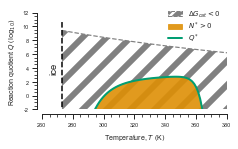

In [267]:
fig, ax = plt.subplots(figsize=(3.4,2.2))

# plot DG=0
ax.plot(Tspace,np.log10(KP),c='grey',linestyle='--')
waite = ax.fill_between(Tspace,np.log10(KP),-10,facecolor='none',hatch='/',edgecolor='grey',linewidth=0.0)

hatch = mpatches.Patch(facecolor="none",hatch='//',edgecolor='grey',linewidth=1,linestyle='--')

# Plot Q < Qstar region
lqstar = np.log10(Qstar) # At high temperature, Qstar is so low that it is numerically approximated by 0, yielding a log error for these values
me = ax.fill_between(Tspace,lqstar,-10,color=palette[1],alpha=0.9)
qstar, = ax.plot(Tspace,lqstar,color=palette[2],linestyle='-',linewidth=2)


# Plot the 273 K limit
ax.plot([273,273],[-4,11],'--k',linewidth=1.5)




## Plot details
ax.text(268,4,'ice',rotation='vertical',horizontalalignment='center',verticalalignment='center')
ax.legend(handles=[hatch,me,qstar],labels=['$\Delta G_{cat} < 0$','$N^* > 0$','$Q^*$'],
          fontsize=7,loc='upper right',bbox_to_anchor=(1.,1.1),labelspacing=0.05,frameon=False)
ax.set_ylim(-2,12)
ax.set_xlim(260,380)
ax.tick_params(labelsize=5.5)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))

ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))

ax.set_xlabel('Temperature, $T$ (K)',fontsize=7)
ax.set_ylabel('Reaction quotient $Q$ ($\log_{10}$)',fontsize=7)
sns.despine(ax=ax,trim=True,offset=5)
plt.tight_layout()

#plt.savefig('figures/habitability_small.svg',bbox_inches='tight')
plt.show()

Optimization terminated successfully.
         Current function value: -3.918747
         Iterations: 19
         Function evaluations: 38


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in log10


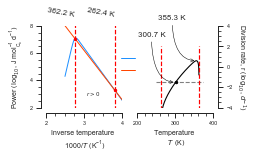

In [260]:
fig, axes = plt.subplots(figsize=(3,1.5), ncols=2,nrows=1)
Tspace    = np.linspace(100,400,500)
ax = axes[0]
ax3= axes[1]

#ax2 = ax.twiny()

Ecat0fun = lambda T : -qmaxfun(T)*bpar['tau']*uhtv.DeltaG0(DG0S=bpar['dg0scat'],DH0S=bpar['dh0scat'],T=T)
Emt0fun  = lambda T : uhtv.MaintenanceE(T)
balance  = lambda T : Ecat0fun(T) - Emt0fun(T)
qanafun  = lambda T : (1/bpar['dgdiss'])*balance(T)
# Required energy production to compensate intrinsinc death rate
threshold= lambda T : (bpar['dth_con']/-(uhtv.DeltaG0(DG0S=bpar['dg0scat'],DH0S=bpar['dh0scat'],T=T)/bpar['dgdiss']))
# qana - d
netgrowth= lambda T : qanafun(T)-bpar['dth_con']

# Ecat - Em
zeroe1   = scopt.root_scalar(balance,bracket=[1000/3,1000/2],method='brentq')
zeroe2   = scopt.root_scalar(balance,bracket=[1000/5,1000/3],method='brentq')
xzero1   = 1000/zeroe1.root
xzero2   = 1000/zeroe2.root
yzero1   = np.log10(Ecat0fun(zeroe1.root))
yzero2   = np.log10(Ecat0fun(zeroe2.root))
# qana -d
zero_netg = scopt.root_scalar(netgrowth,bracket=[200,320],method='brentq')
xzerg    = zero_netg.root
yzerg    = qanafun(xzerg)
topt_est = scopt.fmin(lambda x: -netgrowth(x), 360)[0]
topt_y   = qanafun(topt_est)


Ecat0, = ax.plot(1000/Tspace,np.log10(Ecat0fun(Tspace)),color='dodgerblue',linewidth=1)
Em,    = ax.plot(1000/Tspace,np.log10(Emt0fun(Tspace)),color='orangered',linewidth=1)

# Plot zeroes
ax.plot(xzero1,yzero1,'r.')
ax.plot(xzero2,yzero2,'r.')
ax.plot([xzero1]*2,[-4,8.5],'--r')
ax.plot([xzero2]*2,[-4,8.5],'--r')
ax.text(3.25,3,'$r>0$',horizontalalignment='center',va='center',fontsize=5.5)


ax.tick_params(labelsize=5.5)

ax.set_ylim(2,8)
ax.set_yticks(np.arange(2,10,2))
ax.set_xlim(2,4)
#ax.set_xticks(np.arange(2,6,1))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(.25))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.5))

ax.set_xlabel('Inverse temperature \n 1000/$T$ ($\mathregular{K^{-1}}$)',fontsize=7)
ax.set_ylabel(r'Power ($\log_{10}$, $\mathregular{J~mol_{C_x}^{-1}~d^{-1}}$)',fontsize=7)

ax.legend(handles=[Ecat0,Em],labels=['$\mathit{cat}$','$m$'],loc='upper right',fontsize=7,
          bbox_to_anchor=(1.5,0.75),frameon=False)
sns.despine(ax=ax,trim=True,offset=5)
#ax.text(-0.2,1.1,'(a)',transform=ax.transAxes,fontsize=10)

# Add C scale
#ticks = ax.get_xticks()
#ax2.set_xlim(ax.get_xlim())
#ax2.set_xticks(ticks)
#ax2.set_xticklabels(['{0}'.format(int(np.round(1000/i))) for i in ticks])
#ax2.set_xlabel('Temperature  $T$ (K)')
#sns.despine(ax=ax2,trim=True,offset=5)
ax.text(xzero1,9.0,'{:0.4} K'.format(zeroe1.root),ha='right',va='center',fontsize=8,rotation=-10)
ax.text(xzero2,9.0,'{:0.4} K'.format(zeroe2.root),ha='right',va='center',fontsize=8,rotation=-10)


# Division rate
ax3.plot(Tspace,np.log10(qanafun(Tspace)),'k',linewidth=1.1)
ax3.plot([250,373],np.log10([bpar['dth_con'],bpar['dth_con']]),color='grey',linestyle='--',linewidth=1.1)
ax3.plot([xzerg],[np.log10(yzerg)],'.k')
ax3.annotate(s='{:0.4} K'.format(xzerg),xy=(xzerg,np.log10(yzerg)),
             xytext=(xzerg-100,np.log10(yzerg)+4.5),fontsize=8,rotation=0,
             arrowprops=dict(arrowstyle='->',connectionstyle="angle3",color='k',lw=0.5))

ax3.annotate(s='{:0.4} K'.format(topt_est),xy=(topt_est,np.log10(topt_y)),
             xytext=(topt_est-100,np.log10(topt_y)+4),fontsize=8,rotation=0,
             arrowprops=dict(arrowstyle='->',connectionstyle="angle3",color='k',lw=.5))

ax3.set_xlim(200,400)
#ax3.set_xticks([200,300,400])
ax3.set_ylim(-4,4)
ax3.tick_params(labelsize=5.5)

ax3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax3.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax3.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(20))

ax3.yaxis.set_label_position("right")


ax3.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(.5))

ax3.set_ylabel('Division rate, r ($\log_{10}$, $d^{-1}$)',rotation=270,labelpad=15,fontsize=7)
ax3.set_xlabel('Temperature \n $T$ (K)',fontsize=7)
ax3.plot([zeroe1.root,zeroe1.root],[-10,2],'r--')
ax3.plot([zeroe2.root,zeroe2.root],[-10,2],'r--')
sns.despine(ax=ax3,trim=True,offset=5,left=True,right=False)



#plt.savefig('energies.png',bbox_to_inches='tight')
plt.show()

In [306]:
topt_est-273.15

82.13370666503909

In [307]:
1000/topt_est

2.814652012575399

In [304]:
rad = 1
cellmass = (18e-15*((4/3)*np.pi*rad**3)**0.94)*(12+1*1.8+16*0.5+14*0.2)
diss = cellmass*(qanafun(topt_est)/(60*60*24))*(-uhtv.DeltaG0(DG0S=bpar['dg0scat'],DH0S=bpar['dh0scat'],T=topt_est))/(cellmass**(3/4))
np.log(diss)

-6.027361573835792

Optimization terminated successfully.
         Current function value: -3.918747
         Iterations: 19
         Function evaluations: 38


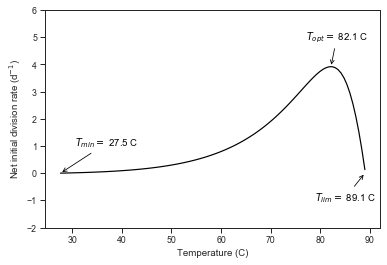

In [187]:
plt.plot(Tspace[netgrowth(Tspace)>0]-273.15,netgrowth(Tspace)[netgrowth(Tspace)>0],'k-')
tmin_est = scopt.root_scalar(netgrowth,bracket=[270,320],method='brentq')
tmax_est = scopt.root_scalar(netgrowth,bracket=[340,380],method='brentq')
topt_est = scopt.fmin(lambda x: -netgrowth(x), 360)

plt.annotate(s='$T_{min}=$'+' {:0.3} C'.format(tmin_est.root-273.15),xy=(np.min(Tspace[netgrowth(Tspace)>0]-273.15),0),
             xytext=(np.min(Tspace[netgrowth(Tspace)>0]-273.15)+3,1),
             arrowprops=dict(arrowstyle='->',connectionstyle="arc3",color='k'),color='k')

plt.annotate(s='$T_{lim}=$'+' {:0.3} C'.format(tmax_est.root-273.15),xy=(np.max(Tspace[netgrowth(Tspace)>0]-273.15),0),
             xytext=(np.max(Tspace[netgrowth(Tspace)>0]-273.15)-10,-1),
             arrowprops=dict(arrowstyle='->',connectionstyle="arc3",color='k'),color='k')

plt.annotate(s='$T_{opt}=$'+' {:0.3} C'.format(topt_est[0]-273.15),xy=(topt_est[0]-273.15,netgrowth(topt_est)),
             xytext=(topt_est[0]-273.15-5,netgrowth(topt_est)+1),
             arrowprops=dict(arrowstyle='->',connectionstyle="arc3",color='k'),color='k')

plt.ylabel('Net initial division rate ($\mathregular{d}^{-1}$)')
plt.xlabel('Temperature (C)')
plt.ylim(-2,6)
#plt.savefig('fictive_methanogen.png',dpi=400,bbox_inches='tight')
plt.show()

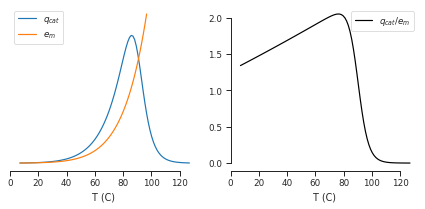

In [25]:
X = np.linspace(280,400,100)
fig, axes = plt.subplots(figsize=(6,3),ncols=2)
#ax.set_ylim(0,1000)
ax = axes[0]
qc, = ax.plot(X-273,qmaxfun(X))
emc, = ax.plot(X[:75]-273,Emt0fun(X[:75]))
ax.legend(handles=[qc,emc],labels=[r'$q_{cat}$',r'$e_m$'],loc='best')
ax.set_yticks(ticks=[])
ax.set_xticks(ticks=[0,20,40,60,80,100,120])

sns.despine(left=True,trim=True,ax=ax)
ax.set_xlabel('T (C)')

ax2 = axes[1]
rat, = ax2.plot(X-273,qmaxfun(X)/Emt0fun(X),'k')
ax2.legend(handles=[rat],labels=[r'$q_{cat}/e_m$'])
ax2.set_xticks(ticks=[0,20,40,60,80,100,120])
ax2.set_xlabel('T (C)')
sns.despine(trim=True,ax=ax2)

plt.tight_layout()
#plt.savefig('figures/qenzyme.png',dpi=400)
plt.show()